# NCAR Innovator Program Project

### Notebook by: Maria J. Molina (NCAR/University of Maryland) and Jessica Moulite (Howard University)

Import packages

In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
def cel_to_far(tmp):
    """
    Convert celsius to farenheit
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append((i * (9/5)) + 32)
    return np.array(newtmp)


def cel_to_nan(tmp):
    """
    Change 9999 to np.nan
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append(i)
    return np.array(newtmp)


def convert_to_datetime(time_value):
    """
    Convert to a datetime object to be able to compute time difference.
    """
    return datetime.datetime(
        pd.to_datetime(time_value).year,
        pd.to_datetime(time_value).month,
        pd.to_datetime(time_value).day,
        pd.to_datetime(time_value).hour,
        pd.to_datetime(time_value).minute,
        pd.to_datetime(time_value).second,
    )


def compute_time_difference(a, b):
    """
    Compute time difference between two times.
    """
    if a >= b:
        return convert_to_datetime(a) - convert_to_datetime(b)
    if b > a:
        return convert_to_datetime(b) - convert_to_datetime(a)
    
    
def extract_era5_time(t_daily, t_full):
    """
    Extract the era5 temperature corresponding time.
    """
    era5_time_array = []
    
    for i, j in zip(t_daily.time, t_daily):
        
        tmp = t_full.sel(
            time=slice(i, pd.to_datetime(i.values) + datetime.timedelta(hours=23)))
        
        era5_time_array.append(tmp.where(tmp == j, drop=True).time.values)
        
    return era5_time_array

### load in our csv file with temperatures from Shading Dade

In [3]:
Shading_dade_temp = pd.read_csv('/Users/molina/Desktop/ShadingDade_NOAA_KMIA_Temperature.csv')

In [4]:
Shading_dade_temp.columns

Index(['Datetime', 'ShadingDade_Temperature_Daily_Max (C)',
       'ShadingDade_Temperature_Daily_Min (C)',
       'NOAA_KMIA_Temperature_Daily_Max (C)',
       'NOAA_KMIA_Temperature_Daily_Min (C)',
       'ShadingDade_Temperature_Daily_Max (F)',
       'ShadingDade_Temperature_Daily_Min (F)',
       'NOAA_KMIA_Temperature_Daily_Max (F)',
       'NOAA_KMIA_Temperature_Daily_Min (F)',
       'Daily_Temperature_Max_Difference (C)',
       'Daily_Temperature_Min_Difference (C)',
       'Daily_Temperature_Max_Difference (F)',
       'Daily_Temperature_Min_Difference (F)',
       'Corresponding_Datetime_ShadingDade_DailyMax',
       'Corresponding_Datetime_ShadingDade_DailyMin',
       'Corresponding_Datetime_NOAA_KMIA_DailyMax',
       'Corresponding_Datetime_NOAA_KMIA_DailyMin',
       'Corresponding_Datetime_NOAA_KMIA_DailyMax_Difference (C)',
       'Corresponding_Datetime_NOAA_KMIA_DailyMax_Difference (F)',
       'Corresponding_Datetime_NOAA_KMIA_DailyMin_Difference (C)',
       'Cor

In [5]:
# location of little haiti temperature sensor
SD_latitude  = 25.8436392
SD_longitude = -80.1816499 % 360

In [6]:
alltmaxtimes = pd.to_datetime(Shading_dade_temp['Corresponding_Datetime_ShadingDade_DailyMax'].values)

In [7]:
# separate by month for easier ERA5 manipulation
jun_tmaxtimes = alltmaxtimes[alltmaxtimes.month == 6]
jul_tmaxtimes = alltmaxtimes[alltmaxtimes.month == 7]
aug_tmaxtimes = alltmaxtimes[alltmaxtimes.month == 8]

In [8]:
alltmintimes = pd.to_datetime(Shading_dade_temp['Corresponding_Datetime_ShadingDade_DailyMin'].values)

In [9]:
jun_tmintimes = alltmintimes[alltmintimes.month == 6]
jul_tmintimes = alltmintimes[alltmintimes.month == 7]
aug_tmintimes = alltmintimes[alltmintimes.month == 8]

### ERA5 work

Download source for ERA5: https://rda.ucar.edu/datasets/ds633.0/

ERA5 (ECMWF -- European Centre for Medium-Range Weather Forecasts -- fifth reanalysis) reference: https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.3803

In [10]:
# open files
ds_jun = xr.open_dataset(
    '/Users/molina/Desktop/e5.oper.an.sfc.128_167_2t.ll025sc.2019060100_2019063023.nc')['VAR_2T']
ds_jul = xr.open_dataset(
    '/Users/molina/Desktop/e5.oper.an.sfc.128_167_2t.ll025sc.2019070100_2019073123.nc')['VAR_2T']
ds_aug = xr.open_dataset(
    '/Users/molina/Desktop/e5.oper.an.sfc.128_167_2t.ll025sc.2019080100_2019083123.nc')['VAR_2T']

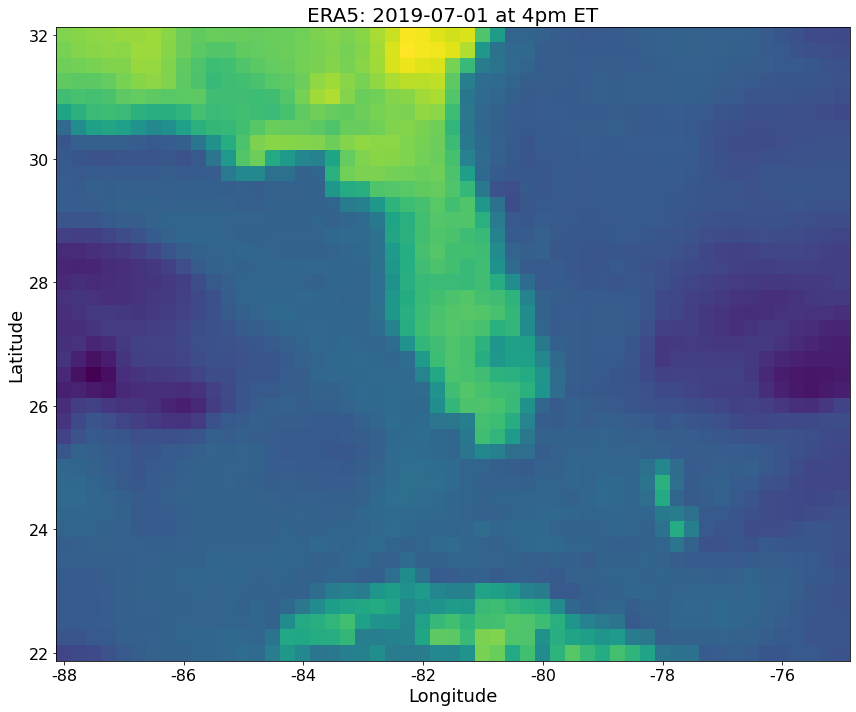

In [11]:
fig, ax = plt.subplots(figsize=(12,10))

(ds_jul.isel(time=20)-273).sel(latitude=slice(32,22), longitude=slice(272,285)).plot.pcolormesh(
      cmap='viridis', ax=ax, add_colorbar=False)

ax.set_title('ERA5: 2019-07-01 at 4pm ET', fontsize=20)
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)

ax.set_yticks([22,24,26,28,30,32])
ax.set_yticklabels([22,24,26,28,30,32], fontsize=16)

ax.set_xticks([272,274,276,278,280,282,284])
ax.set_xticklabels([272-360,274-360,276-360,278-360,280-360,282-360,284-360], fontsize=16)

plt.tight_layout()
plt.savefig('/Users/molina/Desktop/era5_samplegrid.png', dpi=500)
plt.show()

### ERA5 temperature during the Shading Dade daily maximum (2019)

In [12]:
# using max times from previous analysis
era5_temp_corresponding_sdmax_jun = ds_jun.sel(
    longitude=SD_longitude, latitude=SD_latitude, time = jun_tmaxtimes, method='nearest') - 273.15
era5_temp_corresponding_sdmax_jul = ds_jul.sel(
    longitude=SD_longitude, latitude=SD_latitude, time = jul_tmaxtimes, method='nearest') - 273.15
era5_temp_corresponding_sdmax_aug = ds_aug.sel(
    longitude=SD_longitude, latitude=SD_latitude, time = aug_tmaxtimes, method='nearest') - 273.15

In [13]:
# concat all era5 times
era5_temp_corresponding_sdmax = xr.concat([
    era5_temp_corresponding_sdmax_jun,
    era5_temp_corresponding_sdmax_jul,
    era5_temp_corresponding_sdmax_aug,
], dim='time')

### differences (temperature)

In [14]:
# check data lengths
assert len(
    Shading_dade_temp['ShadingDade_Temperature_Daily_Max (C)']) == len(
    era5_temp_corresponding_sdmax.values)

In [15]:
# difference between shading dade temperature maximum and the era5 corresponding temperature at that time (C)
tmax_daily_difference_C = Shading_dade_temp[
    'ShadingDade_Temperature_Daily_Max (C)'] - era5_temp_corresponding_sdmax.values

In [16]:
# difference between shading dade temperature maximum and the era5 corresponding temperature at that time (F)
tmax_daily_difference_F = Shading_dade_temp['ShadingDade_Temperature_Daily_Max (F)'] - cel_to_far(
    era5_temp_corresponding_sdmax.values)

### ERA5 temperature during the Shading Dade daily minimum (2019)

In [17]:
era5_temp_corresponding_sdmin_jun = ds_jun.sel(
    longitude=SD_longitude, latitude=SD_latitude, time = jun_tmintimes, method='nearest') - 273.15
era5_temp_corresponding_sdmin_jul = ds_jul.sel(
    longitude=SD_longitude, latitude=SD_latitude, time = jul_tmintimes, method='nearest') - 273.15
era5_temp_corresponding_sdmin_aug = ds_aug.sel(
    longitude=SD_longitude, latitude=SD_latitude, time = aug_tmintimes, method='nearest') - 273.15

In [18]:
era5_temp_corresponding_sdmin = xr.concat([
    era5_temp_corresponding_sdmin_jun,
    era5_temp_corresponding_sdmin_jul,
    era5_temp_corresponding_sdmin_aug,
], dim='time')

### differences

In [19]:
# check data lengths
assert len(
    Shading_dade_temp['ShadingDade_Temperature_Daily_Min (C)']) == len(
    era5_temp_corresponding_sdmin.values)

In [20]:
# difference between shading dade temperature minimum and the era5 corresponding temperature at that time (C)
tmin_daily_difference_C = Shading_dade_temp[
    'ShadingDade_Temperature_Daily_Min (C)'] - era5_temp_corresponding_sdmin.values

In [21]:
# difference between shading dade temperature minimum and the era5 corresponding temperature at that time (F)
tmin_daily_difference_F = Shading_dade_temp['ShadingDade_Temperature_Daily_Min (F)'] - cel_to_far(
    era5_temp_corresponding_sdmin.values)

### ERA5 daily temperature maximum (2019)

In [22]:
# grab all temps in the nearest grid cell
era5_temp_jun = ds_jun.sel(
    longitude=SD_longitude, latitude=SD_latitude, method='nearest') - 273.15
era5_temp_jul = ds_jul.sel(
    longitude=SD_longitude, latitude=SD_latitude, method='nearest') - 273.15
era5_temp_aug = ds_aug.sel(
    longitude=SD_longitude, latitude=SD_latitude, method='nearest') - 273.15

In [23]:
# compute daily maxs
era5_tmax_jun = era5_temp_jun.resample(time='D').max()
era5_tmax_jul = era5_temp_jul.resample(time='D').max()
era5_tmax_aug = era5_temp_aug.resample(time='D').max()

In [24]:
era5_tmax = xr.concat([
    era5_tmax_jun,
    era5_tmax_jul,
    era5_tmax_aug,
], dim='time')

In [25]:
# slice to the date range of interest
era5_tmax = era5_tmax.sel(time=slice(alltmaxtimes.date[0], alltmaxtimes.date[-1]))

### ERA5 daily temperature minimum (2019)

In [26]:
# compute daily mins
era5_tmin_jun = era5_temp_jun.resample(time='D').min()
era5_tmin_jul = era5_temp_jul.resample(time='D').min()
era5_tmin_aug = era5_temp_aug.resample(time='D').min()

In [27]:
era5_tmin = xr.concat([
    era5_tmin_jun,
    era5_tmin_jul,
    era5_tmin_aug,
], dim='time')

In [28]:
# slice to the date range of interest
era5_tmin = era5_tmin.sel(time=slice(alltmintimes.date[0], alltmintimes.date[-1]))

### ERA5 daily temperature maximum time (2019)

In [29]:
# use func to grab the times of the max temps in era5
era5_tmax_jun_time = extract_era5_time(era5_tmax_jun, era5_temp_jun)
era5_tmax_jul_time = extract_era5_time(era5_tmax_jul, era5_temp_jul)
era5_tmax_aug_time = extract_era5_time(era5_tmax_aug, era5_temp_aug)

In [30]:
# combine all times
era5_tmax_all_time = pd.to_datetime(
    np.vstack([era5_tmax_jun_time,
               era5_tmax_jul_time,
               era5_tmax_aug_time])[:,0])

In [31]:
# remove earlier error times added by func
era5_tmax_time = era5_tmax_all_time[(era5_tmax_all_time>='2019-06-09')]

In [32]:
# absolute time difference between daily maximum temperature (ERA5 and Shading Dade)
tmax_diff = []
for i, j in zip(
    pd.to_datetime(Shading_dade_temp['Corresponding_Datetime_ShadingDade_DailyMax']), era5_tmax_time):
    tmax_diff.append(compute_time_difference(i, j))
tmax_diff = np.array(tmax_diff)

### ERA5 daily temperature minimum time (2019)

In [33]:
# use func to grab the times of the min temps in era5
era5_tmin_jun_time = extract_era5_time(era5_tmin_jun, era5_temp_jun)
era5_tmin_jul_time = extract_era5_time(era5_tmin_jul, era5_temp_jul)
era5_tmin_aug_time = extract_era5_time(era5_tmin_aug, era5_temp_aug)

In [34]:
# concat
era5_tmin_all_time = pd.to_datetime(
    np.vstack([era5_tmin_jun_time,
               era5_tmin_jul_time,
               era5_tmin_aug_time])[:,0])

In [35]:
# remove earlier error times added by func
era5_tmin_time = era5_tmin_all_time[(era5_tmin_all_time>='2019-06-09')]

In [36]:
# absolute time difference between daily minimum temperature (ERA5 and Shading Dade)
tmin_diff = []
for i, j in zip(
    pd.to_datetime(Shading_dade_temp['Corresponding_Datetime_ShadingDade_DailyMin']), era5_tmin_time):
    tmin_diff.append(compute_time_difference(i, j))
tmin_diff = np.array(tmin_diff)

### create single csv file

In [37]:
data = {
'ShadingDade_Temperature_Daily_Max (C)' : Shading_dade_temp['ShadingDade_Temperature_Daily_Max (C)'],
'ShadingDade_Temperature_Daily_Max (F)' : Shading_dade_temp['ShadingDade_Temperature_Daily_Max (F)'],
    
'ShadingDade_Temperature_Daily_Min (C)' : Shading_dade_temp['ShadingDade_Temperature_Daily_Min (C)'],
'ShadingDade_Temperature_Daily_Min (F)' : Shading_dade_temp['ShadingDade_Temperature_Daily_Min (F)'],
    
'ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Max (C)': era5_temp_corresponding_sdmax.values,
'ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Max (F)': cel_to_far(era5_temp_corresponding_sdmax.values),
    
'ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Min (C)': era5_temp_corresponding_sdmin.values,
'ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Min (F)': cel_to_far(era5_temp_corresponding_sdmin.values),

'Daily_Temperature_Max_Difference (C)': tmax_daily_difference_C.values,
'Daily_Temperature_Max_Difference (F)': tmax_daily_difference_F.values,
    
'Daily_Temperature_Min_Difference (C)': tmin_daily_difference_C.values,
'Daily_Temperature_Min_Difference (F)': tmin_daily_difference_F.values,
    
'ERA5_Temperature_Daily_Max (C)': era5_tmax.values,
'ERA5_Temperature_Daily_Max (F)': cel_to_far(era5_tmax.values),
'ERA5_Temperature_Daily_Max_Datetime': era5_tmax_time,
    
'ERA5_Temperature_Daily_Min (C)': era5_tmin.values,
'ERA5_Temperature_Daily_Min (F)': cel_to_far(era5_tmin.values),
'ERA5_Temperature_Daily_Min_Datetime': era5_tmin_time,
    
'Absolute_time_difference_tmax_ERA5_ShadingDade (day H:M:S)': tmax_diff,
'Absolute_time_difference_tmin_ERA5_ShadingDade (day H:M:S)': tmin_diff,

       }

In [38]:
df_FINAL = pd.DataFrame(data)

In [39]:
df_FINAL

,ShadingDade_Temperature_Daily_Max (C),ShadingDade_Temperature_Daily_Max (F),ShadingDade_Temperature_Daily_Min (C),ShadingDade_Temperature_Daily_Min (F),ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Max (C),ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Max (F),ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Min (C),ERA5_Corresponding_Temperature_During_ShadingDade_Daily_Min (F),Daily_Temperature_Max_Difference (C),Daily_Temperature_Max_Difference (F),Daily_Temperature_Min_Difference (C),Daily_Temperature_Min_Difference (F),ERA5_Temperature_Daily_Max (C),ERA5_Temperature_Daily_Max (F),ERA5_Temperature_Daily_Max_Datetime,ERA5_Temperature_Daily_Min (C),ERA5_Temperature_Daily_Min (F),ERA5_Temperature_Daily_Min_Datetime,Absolute_time_difference_tmax_ERA5_ShadingDade (day H:M:S),Absolute_time_difference_tmin_ERA5_ShadingDade (day H:M:S)
0,33.750,92.750,25.125,77.225,26.792572,80.226630,27.670563,81.807013,6.957428,12.523370,-2.545563,-4.582013,28.871124,83.968024,2019-06-09 16:00:00,26.113495,79.004291,2019-06-09 11:00:00,0 days 04:00:00,0 days 10:00:00
1,38.500,101.300,23.250,73.850,26.699921,80.059857,26.314667,79.366400,11.800079,21.240143,-3.064667,-5.516400,29.251984,84.653571,2019-06-10 19:00:00,25.005402,77.009723,2019-06-10 09:00:00,0 days 03:00:00,0 days 02:00:00
2,40.750,105.350,24.250,75.650,27.057831,80.704095,26.604706,79.888470,13.692169,24.645905,-2.354706,-4.238470,30.506561,86.911810,2019-06-11 18:00:00,25.968292,78.742926,2019-06-11 09:00:00,0 days 06:00:00,0 days 06:00:00
3,40.250,104.450,24.875,76.775,26.922882,80.461188,26.931915,80.477448,13.327118,23.988812,-2.056915,-3.702448,30.096771,86.174188,2019-06-12 18:00:00,26.637909,79.948236,2019-06-12 08:00:00,0 days 07:00:01,0 days 04:00:00
4,41.000,105.800,25.125,77.225,27.729523,81.913141,28.046173,82.483112,13.270477,23.886859,-2.921173,-5.258112,30.056000,86.100800,2019-06-13 19:00:00,26.520447,79.736804,2019-06-13 10:00:00,0 days 07:00:00,0 days 12:59:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,42.250,108.050,25.000,77.000,27.405975,81.330756,27.472656,81.450781,14.844025,26.719244,-2.472656,-4.450781,30.495148,86.891266,2019-08-27 18:00:00,25.706940,78.272491,2019-08-27 10:00:00,0 days 05:00:00,0 days 06:00:00
80,40.750,105.350,24.625,76.325,28.515808,83.328455,26.947937,80.506287,12.234192,22.021545,-2.322937,-4.181287,31.926544,89.467780,2019-08-28 19:00:00,26.544891,79.780804,2019-08-28 11:00:00,0 days 05:00:01,0 days 05:00:00
81,41.375,106.475,24.750,76.550,27.561676,81.611017,27.436249,81.385248,13.813324,24.863983,-2.686249,-4.835248,29.879425,85.782965,2019-08-29 16:00:00,26.211426,79.180566,2019-08-29 08:00:00,0 days 03:00:00,0 days 04:00:00
82,35.000,95.000,23.875,74.975,27.451202,81.412164,26.376740,79.478131,7.548798,13.587836,-2.501740,-4.503131,29.632477,85.338458,2019-08-30 22:00:00,26.315643,79.368158,2019-08-30 07:00:00,0 days 08:00:01,0 days 00:59:59


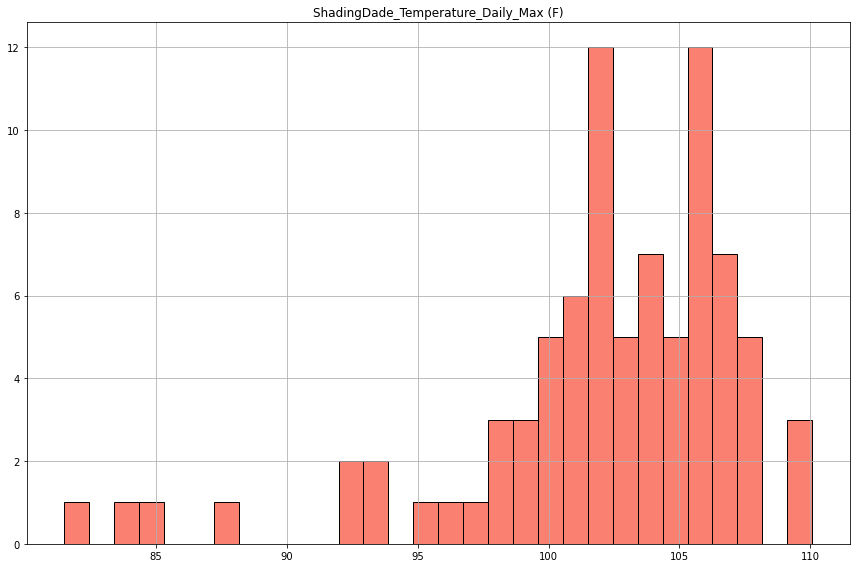

In [40]:
fig = df_FINAL.hist(
    'ShadingDade_Temperature_Daily_Max (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.savefig('/Users/molina/Desktop/ShadingDade_Temperature_Daily_Max.png', dpi=500)
plt.show()

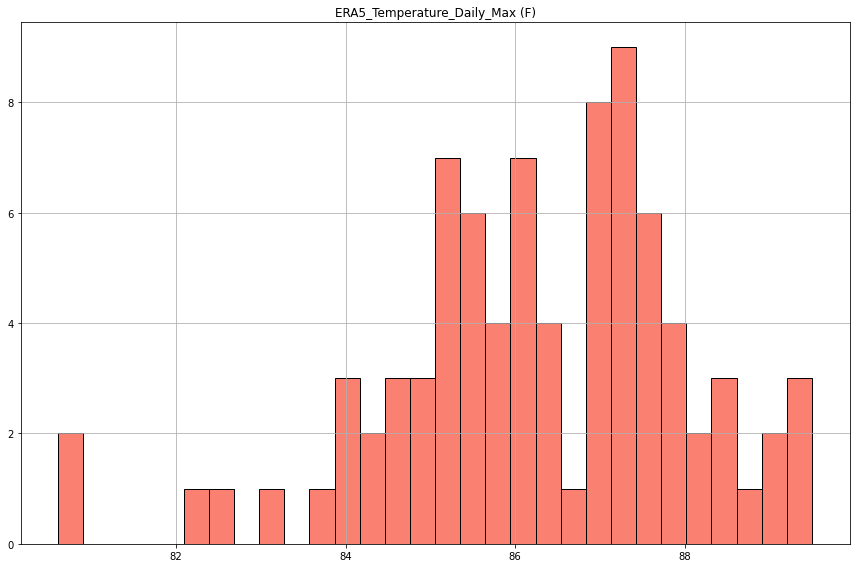

In [41]:
df_FINAL.hist('ERA5_Temperature_Daily_Max (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.savefig('/Users/molina/Desktop/ERA5_Temperature_Daily_Max.png', dpi=500)
plt.show()

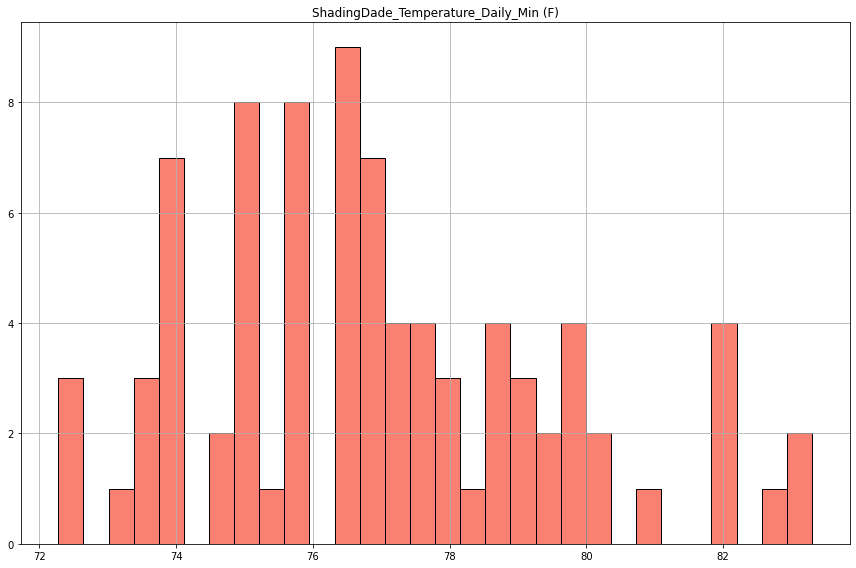

In [42]:
df_FINAL.hist('ShadingDade_Temperature_Daily_Min (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.savefig('/Users/molina/Desktop/ShadingDade_Temperature_Daily_Min.png', dpi=500)
plt.show()

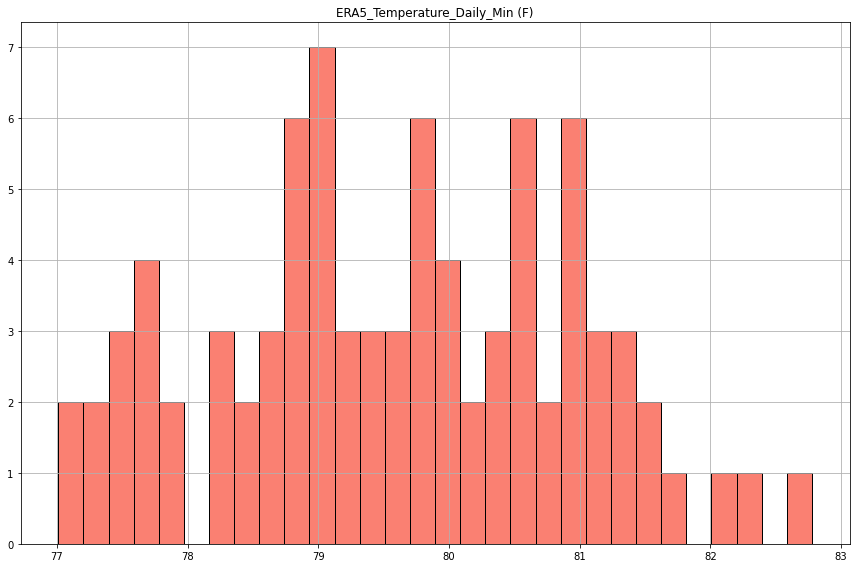

In [43]:
df_FINAL.hist('ERA5_Temperature_Daily_Min (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.savefig('/Users/molina/Desktop/ERA5_Temperature_Daily_Min.png', dpi=500)
plt.show()

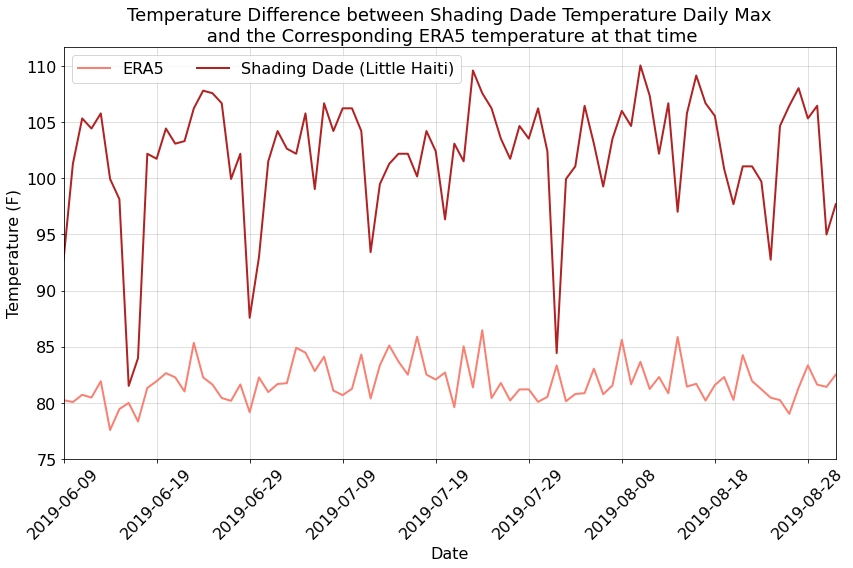

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title(
    'Temperature Difference between Shading Dade Temperature Daily Max\n and the Corresponding ERA5 temperature at that time', 
    fontsize=18)

ls0, = ax.plot(cel_to_far(era5_temp_corresponding_sdmax.values), color='salmon', lw=2.0)
ls1, = ax.plot(Shading_dade_temp['ShadingDade_Temperature_Daily_Max (F)'].values, color='firebrick', lw=2.0)

ax.legend([ls0,ls1],['ERA5','Shading Dade (Little Haiti)'],
          fancybox=True, fontsize=16, ncol=2)

ax.set_xticks(np.arange(0,era5_temp_corresponding_sdmax.time.shape[0])[::10])
ax.set_xticklabels(pd.to_datetime(era5_temp_corresponding_sdmax.time).strftime('%Y-%m-%d').values[::10], 
                   rotation=45, fontsize=16)
ax.set_xlabel('Date', fontsize=16)

ax.set_yticks(np.arange(75,111,1)[::5])
ax.set_yticklabels(np.arange(75,111,1)[::5], fontsize=16)
ax.set_ylabel('Temperature (F)', fontsize=16)

ax.grid('--', alpha=0.5)
ax.margins(x=0)

plt.tight_layout()
plt.savefig('/Users/molina/Desktop/TempDiff_SDandERA5.png', dpi=500)
plt.show()


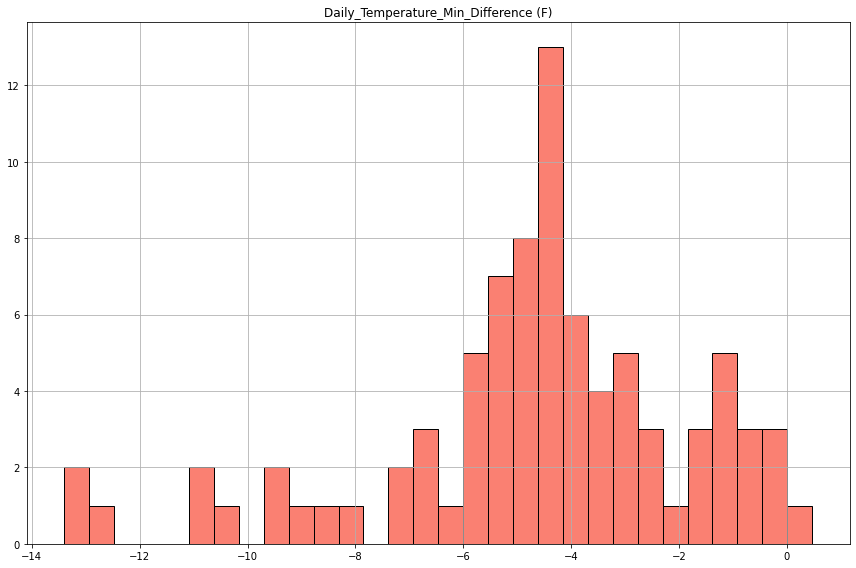

In [45]:
df_FINAL.hist('Daily_Temperature_Min_Difference (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.savefig('/Users/molina/Desktop/Daily_Temperature_Min_Difference.png', dpi=500)
plt.show()

### save csv file

In [46]:
df_FINAL.to_csv('/Users/molina/Desktop/ShadingDade_ERA5_Temperature.csv')